In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

In [ ]:
# connecting google drive to use dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_location = 'drive/MyDrive/fer2013/fer2013.csv'

### **DATA PREPROCESSING**

In [ ]:
# load data function is used to load data from the CSV file and return images and labels in the form of one hot encoded value
def load_data():
  # loading dataset as Dataframe
  dataset = pd.read_csv(file_location)
  images = []
  # converting each image data to float and reshaping it to 48 x 48
  for img in dataset.pixels:
    reshapedImage = np.fromstring(img, dtype=float, sep=' ').reshape(48,48)
    # append all images
    images.append(reshapedImage);

  # converting labels to one hot encoded values of float32
  emotions = pd.get_dummies(dataset.emotion).values.astype('float32')
  # return processed images and emotions
  return images, emotions

images, emotions = load_data()

In [ ]:
# Splitting data into train, test and validation
X_train, X_rem, y_train, y_rem = train_test_split(images, emotions, train_size=0.8, shuffle=True)

# Splitting remaining data in half as validation and test data
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, shuffle=True)

# this function is used to change the data mean to 0 and standard deviation to 1
def standarize_data(data):
    # convert data to float32
    data = np.array(data, 'float32')
    # subtract mean from the data
    data -= np.mean(data, axis=0)
    # dividing the data with standard deviation
    data /= np.std(data, axis=0)
    return data

# standardizing all data
X_train = standarize_data(X_train)
X_test = standarize_data(X_test)
X_valid = standarize_data(X_valid)

In [ ]:
# reshaping data into image
X_train = X_train.reshape(X_train.shape[0], 48,48,1)
X_test = X_test.reshape(X_test.shape[0], 48,48,1)
X_valid = X_valid.reshape(X_valid.shape[0], 48,48,1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#parameters for number of training epochs and path to store and load the notebook
epochs = 50
path = 'drive/MyDrive/Colab Notebooks/'

In [ ]:
# it is used to generate image using ImageDataGenerator
# It rotates the image in 20 degree range, shift the width and height, flip the image horizontally, and zoom the image
image_augmentation = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        horizontal_flip=True,
                        featurewise_std_normalization=False,
                        zoom_range=.2
                        )

### **MODEL STRUCTURE**

In [ ]:
# Defining model Structure
model = Sequential()

# Each block contain same type of layers, the only difference being the filter in Conv2D layer
# Block 1
# Input layer with input shape of 48 x 48 x 1 and 32 filters
model.add(Conv2D(32,(3,3),padding='same' ,input_shape=(48,48,1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Block 2
model.add(Conv2D(64,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Block 3
model.add(Conv2D(128,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Block 4
model.add(Conv2D(256,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Dense Network
# the data from the previous layer is flattened and is passed to Dense layer
model.add(Flatten())
# Dense layer with 256 neurons
model.add(Dense(256, activation='relu'))
# Dense layer with 128 neurons
model.add(Dense(128, activation='relu'))
# Dense layer with 64 neurons
model.add(Dense(64, activation='relu'))

# Output layer that returns probability distribution
model.add(Dense(7, activation='softmax'))

In [ ]:
# defining loss function, optimizer, and metrics
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# displaying the model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_40 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_41 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_41 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                      

### **CALLBACKS**

In [ ]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
log_file_path = path + 'log/'+ 'emotion.log'

# Logging the model output in a log file and storing it in Drive
csv_logger = CSVLogger(log_file_path, append=False)

# Stopping the model if the validation loss does not increase over during 5 epochs
early_stop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

# Store the values of model during training so it can be loaded in the model
checkpoint = ModelCheckpoint(path + '/training/emotion.ckpt',
                             save_weights_only=True,
                             verbose=1)

callbacks = [csv_logger, early_stop, checkpoint]

### **MODEL TRAINING**

In [ ]:
# Training the model using augmented data created with Training data
m = model.fit(image_augmentation.flow(X_train, y_train, 64), 
                    # data for validation
                    validation_data = (X_valid, y_valid),
                    # shuffling the data
                    shuffle = True,
                    # display the training process and the data
                    verbose = 1,
                    # number of rounds to train
                    epochs = epochs, 
                    steps_per_epoch = len(X_train)/64,
                    callbacks = callbacks)

Epoch 1/50
449/448 [==============================] - ETA: 0s - loss: 1.7540 - accuracy: 0.2837
Epoch 1: saving model to drive/MyDrive/Colab Notebooks//training/emotion.ckpt
448/448 [==============================] - 27s 57ms/step - loss: 1.7540 - accuracy: 0.2837 - val_loss: 1.6323 - val_accuracy: 0.3639
Epoch 2/50
449/448 [==============================] - ETA: 0s - loss: 1.5095 - accuracy: 0.4091
Epoch 2: saving model to drive/MyDrive/Colab Notebooks//training/emotion.ckpt
448/448 [==============================] - 23s 52ms/step - loss: 1.5095 - accuracy: 0.4091 - val_loss: 1.5745 - val_accuracy: 0.4235
Epoch 3/50
449/448 [==============================] - ETA: 0s - loss: 1.3417 - accuracy: 0.4854
Epoch 3: saving model to drive/MyDrive/Colab Notebooks//training/emotion.ckpt
448/448 [==============================] - 24s 53ms/step - loss: 1.3417 - accuracy: 0.4854 - val_loss: 1.2223 - val_accuracy: 0.5244
Epoch 4/50
449/448 [==============================] - ETA: 0s - loss: 1.2594 - 

In [ ]:
# Evaluate model with test data
model.evaluate(X_test, y_test)

113/113 [==============================] - 1s 11ms/step - loss: 0.9295 - accuracy: 0.6581


[0.9295469522476196, 0.6581220626831055]

### **SAVE MODEL**

In [ ]:
# Saving model using in drive
model.save('drive/MyDrive/Colab Notebooks/models/emotion.hdf5')

### **DATA VISUALIZATION**

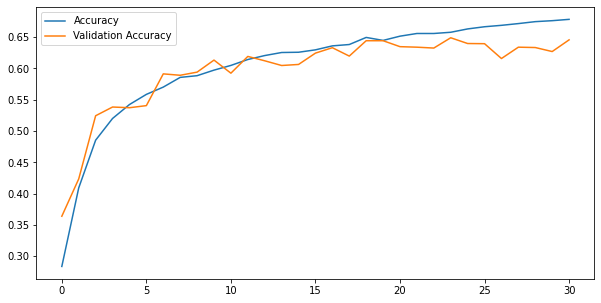

In [ ]:
# Read the log file from the drive
log = pd.read_csv('drive/MyDrive/Colab Notebooks/log/emotion.log')

# Plotting the figure of accuracy and validation accuracy over epoch
plt.figure(figsize=(10,5))
# Plot the data from the model
plt.plot(m.history['accuracy'], label='Accuracy')
plt.plot(m.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

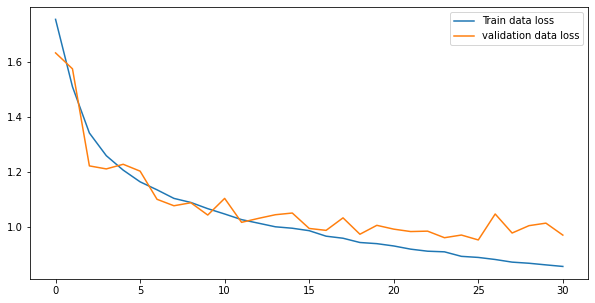

In [ ]:
# Plot of Training data loss and Validation data loss
plt.figure(figsize=(10,5))
plt.plot(m.history['loss'], label='Train data loss')
plt.plot(m.history['val_loss'], label='Validation data loss')
plt.legend()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Predicting the test data
test_data_prediction = model.predict(X_test).argmax(axis=1)

# converting the one hot encoded labels to single value labels
label_x_test = np.array(y_test)
label_x_test = np.where(label_x_test)[1]

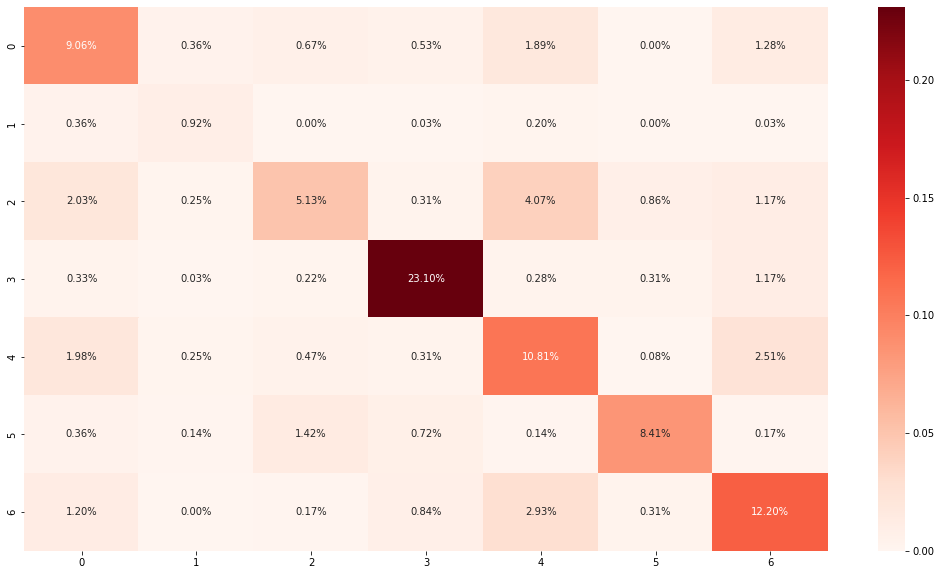

In [ ]:
# Get values of confusion matrix using the confusion_matrix function from sklearn.metrics
confusion_matrix_values = confusion_matrix(label_x_test, test_data_prediction)
plt.figure(figsize = (18,10))
# generate a heatmap using seaborn and display the data in terms of percentage
sns.heatmap(confusion_matrix_values/np.sum(confusion_matrix_values), annot=True, fmt='0.2%', cmap='Reds')

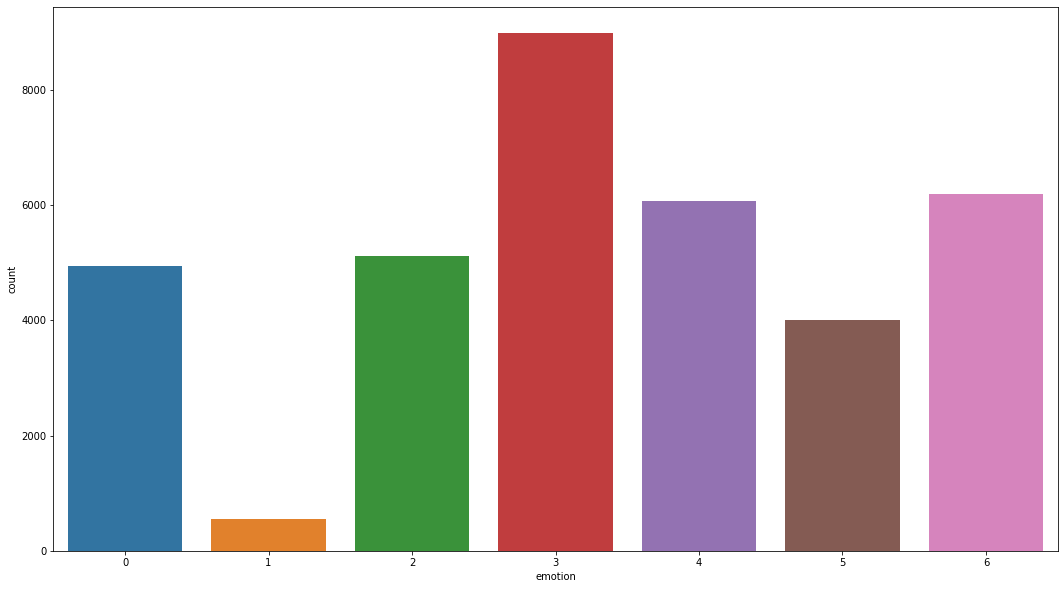

In [ ]:
# Count Plot
# Displays the number of data in each labels
plt.figure(figsize = (18,10))
dataset = pd.read_csv(file_location)
# Plot using countplot
sns.countplot(x='emotion', data = dataset)
# 'Disgust' has the lowest number of data whereas 'Happy' has the highest

### **Image Prediction**

In [ ]:
# Function to predict test data and display the image including the actual and model predicted values
def predict(val):
  # reshaping the test data to array of image
  img = X_test[val].reshape(1,48,48,1)
  # defining emotions
  expressions = ["angry","disgust","scared", "happy", "sad", "surprised","neutral"]
  # plot the image in graph
  plt.imshow(X_test[val].reshape(48,48) ,cmap='gray')
  plt.show()
  # display the actual and predicted values
  print("Actual : ", expressions[np.argmax(y_test[val])])
  print("Predicted: ",expressions[np.argmax(model.predict(img)[0])])

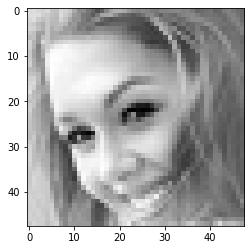

Actual :  happy
Predicted:  happy


In [ ]:
predict(3)

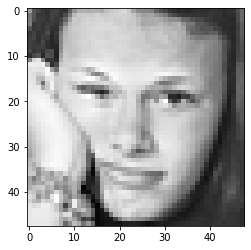

Actual :  neutral
Predicted:  neutral


In [ ]:
predict(4)

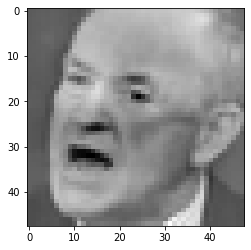

Actual :  angry
Predicted:  angry


In [ ]:
predict(5)

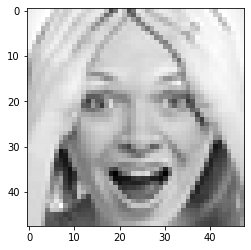

Actual :  surprised
Predicted:  surprised


In [ ]:
predict(11)

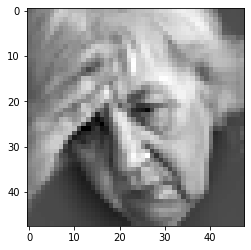

Actual :  sad
Predicted:  sad


In [ ]:
predict(13)

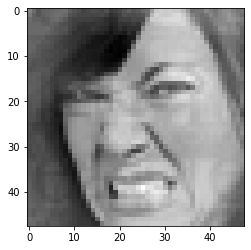

Actual :  disgust
Predicted:  disgust


In [ ]:
predict(16)

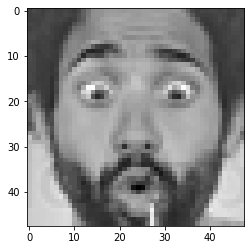

Actual :  scared
Predicted:  scared


In [ ]:
predict(29)